In [1]:
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
import math

In [2]:
class Decompressor():
    def __init__(self,file,read_bin=False):
        self.file = file
        self.read_bin=read_bin
    
        if read_bin:
            file="output/"+file+".bin"
            with open(file , 'rb') as f:
                bin_data = f.read()

            # 讀取圖片 高 , 寬 , rangeSize , domainSize , stepSize
            data=[[]]
            for i in range(5):
                data[0].append(bin_data[i])
            bin_data=bin_data[5:]

            # 讀取  D索引(2維) , 轉換方法(0~7)  , s(0,0.25,0.5,0.75,1) , o(0~128)
            count=0
            col = data[0][1]//data[0][2]
            for i in bin_data:
                if count==0:
                    temp=[]
                if count%5==0:
                    temp_=[]
                temp_.append(i)
                count+=1
                if count%5==0:
                    temp.append(temp_)
                if count >= col*5:
                    data.append(temp)
                    count=0
        else:
            file="output/"+file+".json"
            with open(file , 'r') as file:
                data = json.load(file)

        self.data=data
        # 讀取原圖大小以及壓縮資訊
        _,_,self.rangeSize,self.domainSize,self.stepSize=self.data[0]
        self.data=self.data[1:]
        # 與原圖大小相同的隨機圖片當作輸入
        self.output= [np.random.randint(0,256,(data[0][0],data[0][1]))]
        

    def transform(self,D_block,method):
        match method:
            case 0:
                # 無轉換
                return D_block
            case 1:
                # 左右翻轉
                return np.fliplr(D_block)
            case 2:
                # 上下翻轉
                return np.flipud(D_block)
            case 3:
                # 主對角對稱
                return D_block.T
            case 4:
                # 次對角對稱
                return np.flip(D_block.T)
            case 5:
                # 旋轉90度
                return np.rot90(D_block,1)
            case 6:
                # 旋轉180度
                return np.rot90(D_block,2)
            case 7:
                # 旋轉270度
                return np.rot90(D_block,3)
            case _:
                return D_block
    
    # 解壓
    def deCompress(self):
        # 將圖片按照壓縮過程分割成同樣位置的Domain Block
        Odomain_Blocks=np.empty(((self.output[-1].shape[0]-self.domainSize)//self.stepSize+1,(self.output[-1].shape[1]-self.domainSize)//self.stepSize+1,self.domainSize,self.domainSize),np.uint8)
        for row in range(Odomain_Blocks.shape[0]):
            for col in range(Odomain_Blocks.shape[1]):
                Odomain_Blocks[row,col]=self.output[-1][row*self.stepSize:row*self.stepSize+self.domainSize,col*self.stepSize:col*self.stepSize+self.domainSize].copy()

        # Domain Block均值收縮成Range Block大小
        OdomainContraction_Blocks=np.empty((Odomain_Blocks.shape[0],Odomain_Blocks.shape[1],self.rangeSize,self.rangeSize),np.uint8)
        for row in range(Odomain_Blocks.shape[0]):
            for col in range(Odomain_Blocks.shape[1]):
                OdomainContraction_Blocks[row,col]=cv2.resize(Odomain_Blocks[row,col],(self.rangeSize,self.rangeSize))

        # 還原回Range Block
        output=self.output[-1].copy()
        for row in range(len(self.data)):
            for col in range(len(self.data[row])):
                # 將D根據壓縮的轉換方法轉換
                D_block=self.transform(OdomainContraction_Blocks[self.data[row][col][0]][self.data[row][col][1]],self.data[row][col][2])
                # 按照轉換公式 D*s+o = R 算出新的R
                D_block=D_block*(self.data[row][col][3])+self.data[row][col][4]
                # 大於255的值設為255
                D_block=np.clip(D_block,0,255)
                # 把計算結果當成新的R塊
                output[row*self.rangeSize:((row+1)*self.rangeSize),col*self.rangeSize:(col+1)*self.rangeSize]=D_block
        
        # 將所有新的R塊結合在一起，就是一次迭代後輸出的圖
        self.output.append(output)

    def show_output(self):
        plt.figure()
        nb_row = math.ceil(np.sqrt(11))
        nb_cols = nb_row
        # Plot
        for i, img in enumerate(self.output[-11:]):
            plt.subplot(nb_row, nb_cols, i+1)
            plt.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
            plt.title(str(i))
            frame = plt.gca()
            frame.axes.get_xaxis().set_visible(False)
            frame.axes.get_yaxis().set_visible(False)
        plt.tight_layout()
        
    def compute_PSNR(self):
        # 峰值訊號與雜訊比（Peak Signal-to-Noise Ratio）
        original=cv2.cvtColor(cv2.imread(self.file+".jpg"),cv2.COLOR_RGB2GRAY)
        sum=0
        for row in range(original.shape[0]):
            for col in range(original.shape[1]):
                sum += (original[row][col]-self.output[-1][row][col])**2
        MSE = sum / (original.shape[0]*original.shape[1])
        PSNR = 10*math.log10(255**2/MSE)
        print(PSNR)


In [23]:
decompressor=Decompressor("house")

In [24]:
for i in range(10):
    decompressor.deCompress()

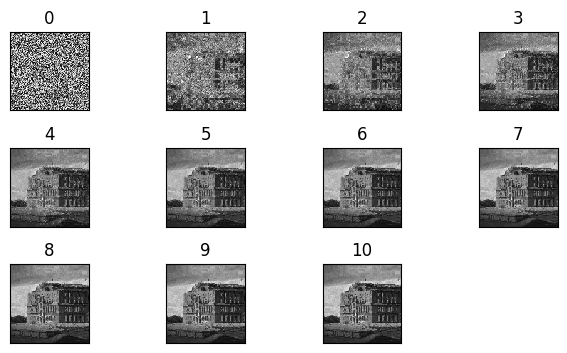

In [25]:
decompressor.show_output()

In [54]:
cv2.imwrite("output/"+decompressor.file+".jpg" ,decompressor.output[-1])

True

In [26]:
# 峰值訊號與雜訊比（Peak Signal-to-Noise Ratio）
decompressor.compute_PSNR()

19.122196447377313
